## 📝 Projeto – LightGBM

Uma empresa de importação de bebidas precisa planejar as próximas aquisições de vinhos do exterior e, para isso, deseja **estimar a qualidade** do vinho com base nas características de cada produto.

Para isso, o time de ciência de dados vai construir um modelo usando um **dataset com mais de 20.000 linhas**, contendo informações como:

- 🍇 Total de ácidos cítricos  
- 💧 Densidade  
- ⚗️ pH  
- …entre outras características técnicas

Dada a **complexidade do desafio** e o **tamanho do dataset**, será utilizado um **ensemble LightGBM** para:

1. 🎯 **Predizer a qualidade** do vinho  
2. 🔍 **Identificar as variáveis** que mais contribuem para essa predição

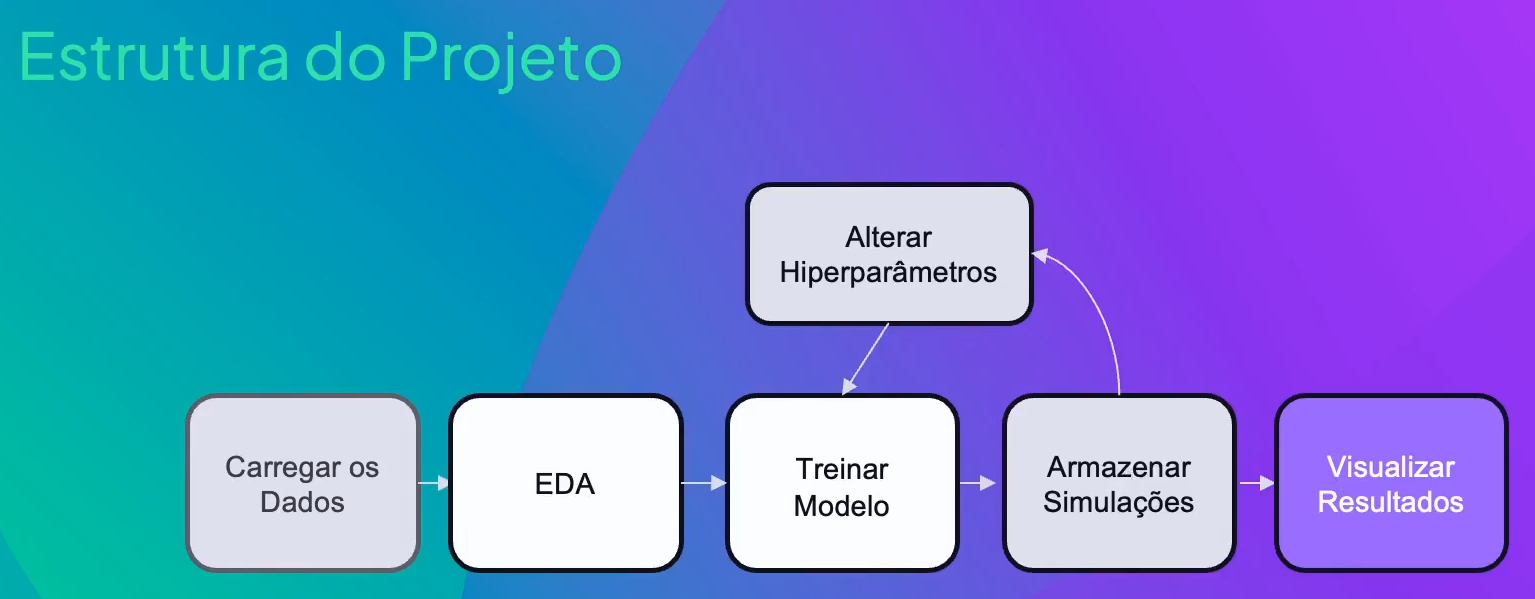

In [1]:
# Importar bibliotecas

# EDA
import pandas as pd
import numpy as np

# Visualização
import plotly.express as px
import matplotlib.pyplot as plt

# Configurações
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.printoptions(suppress=True, precision=3)

# Machine Learning
from lightgbm import LGBMClassifier, early_stopping, plot_tree, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, \
    ConfusionMatrixDisplay, log_loss

# Otimização Bayesiana
from bayes_opt import BayesianOptimization

### Carregar os dados

In [2]:
df_vinhos = pd.read_csv('./datasets/wine_data.csv')

### Visualizar Esatrutura

In [3]:
df_vinhos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21000 entries, 0 to 20999
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         21000 non-null  float64
 1   volatile_acidity      21000 non-null  float64
 2   citric_acid           21000 non-null  float64
 3   residual_sugar        21000 non-null  float64
 4   chlorides             21000 non-null  float64
 5   free_sulfur_dioxide   21000 non-null  float64
 6   total_sulfur_dioxide  21000 non-null  float64
 7   density               21000 non-null  float64
 8   pH                    21000 non-null  float64
 9   sulphates             21000 non-null  float64
 10  alcohol               21000 non-null  float64
 11  quality               21000 non-null  int64  
dtypes: float64(11), int64(1)
memory usage: 1.9 MB


In [4]:
# Visualizar primeiros registros
df_vinhos.head(10)

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0         11.600             0.580        0.660           2.200      0.074   
1         10.400             0.610        0.490           2.100      0.200   
2          7.400             1.185        0.000           4.250      0.097   
3         10.400             0.440        0.420           1.500      0.145   
4          8.300             1.020        0.020           3.400      0.084   
5          7.600             1.580        0.000           2.100      0.137   
6          6.800             0.815        0.000           1.200      0.267   
7          7.300             0.980        0.050           2.100      0.061   
8          7.100             0.875        0.050           5.700      0.082   
9          6.700             0.760        0.020           1.800      0.078   

   free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
0               10.000                47.000    1.001 3.250      0.570   
1                5.000                16.000    0.999 3.160      0.630   
2                5.000                14.000    0.997 3.630      0.540   
3               34.000                48.000    0.998 3.380      0.860   
4                6.000                11.000    0.999 3.480      0.490   
5                5.000                 9.000    0.995 3.500      0.400   
6               16.000                29.000    0.995 3.320      0.510   
7               20.000                49.000    0.997 3.310      0.550   
8                3.000                14.000    0.998 3.400      0.520   
9                6.000                12.000    0.996 3.550      0.630   

   alcohol  quality  
0    9.000        3  
1    8.400        3  
2   10.700        3  
3    9.900        3  
4   11.000        3  
5   10.900        3  
6    9.800        3  
7    9.700        3  
8   10.200        3  
9    9.950        3

In [5]:
# Visualizar últimos registros
df_vinhos.tail(10)

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  \
20990         12.300             1.210        0.680          59.100   
20991         10.200             0.610        0.880          53.800   
20992         12.900             0.900        1.160          51.200   
20993         13.000             0.580        1.220          52.800   
20994         12.800             0.850        1.120          44.900   
20995          9.700             1.020        0.910          50.000   
20996         10.200             0.610        0.880          53.800   
20997         13.400             0.460        1.040          52.100   
20998          6.600             1.030        1.090          25.300   
20999          9.300             0.930        1.320          33.600   

       chlorides  free_sulfur_dioxide  total_sulfur_dioxide  density    pH  \
20990      0.328              232.000               396.000    1.034 3.120   
20991      0.250               62.400               204.700    1.028 3.520   
20992      0.309              196.900               172.300    1.030 3.100   
20993      0.247               93.000               190.700    1.019 3.380   
20994      0.188              215.300               253.300    1.022 3.130   
20995      0.412              114.600               181.700    1.021 3.300   
20996      0.250               62.400               204.700    1.028 3.520   
20997      0.449               63.000               273.500    1.026 2.890   
20998      0.138              179.800               295.000    1.025 2.940   
20999      0.412              128.700               290.100    1.022 3.160   

       sulphates  alcohol  quality  
20990      0.590   12.200        9  
20991      1.140    9.700        9  
20992      0.820   12.400        9  
20993      1.240    9.900        9  
20994      0.810   11.400        9  
20995      0.890   12.000        9  
20996      1.140    9.700        9  
20997      1.760    9.300        9  
20998      1.540   12.900        9  
20999      1.420   13.000        9

In [6]:
# Estatísticas descritivas
df_vinhos.describe()

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  \
count      21000.000         21000.000    21000.000       21000.000   
mean           9.797             0.775        0.794          31.289   
std            2.414             0.365        0.385          19.015   
min            3.800             0.080        0.000           0.600   
25%            7.600             0.430        0.410           9.800   
50%           10.000             0.830        0.870          37.600   
75%           11.800             1.080        1.110          46.800   
max           15.900             1.580        1.660          65.800   

       chlorides  free_sulfur_dioxide  total_sulfur_dioxide   density  \
count  21000.000            21000.000             21000.000 21000.000   
mean       0.200              129.442               229.009     1.010   
std        0.125               77.167               100.183     0.012   
min        0.009                1.000                 6.000     0.987   
25%        0.072               45.000               150.000     0.997   
50%        0.205              145.800               240.500     1.012   
75%        0.298              194.325               311.625     1.020   
max        0.611              289.000               440.000     1.039   

             pH  sulphates   alcohol   quality  
count 21000.000  21000.000 21000.000 21000.000  
mean      3.159      1.021    11.292     6.000  
std       0.171      0.408     1.182     2.000  
min       2.720      0.220     8.000     3.000  
25%       3.030      0.620    10.400     4.000  
50%       3.150      1.080    11.300     6.000  
75%       3.270      1.360    12.200     8.000  
max       4.010      2.000    14.900     9.000

### EDA

In [7]:
# Distribuição das variáveis numéricas
numerical_cols = df_vinhos.drop(columns=['quality']).columns

# Visualizar distribuição das variáveis numéricas
for col in numerical_cols:
    fig = px.histogram(df_vinhos, x=col, nbins=20, title=f'Distribuição de {col}')
    fig.show()

In [8]:
# Distribuição da variável target
df_count = df_vinhos['quality'].value_counts().reset_index()
df_count.columns = ['quality', 'contagem']

fig = px.bar(df_count, x='quality', y='contagem', title='Distribuição da variável target')
fig.show()

In [9]:
# Analisando relação entre variáveis numéricas e target
for col in numerical_cols:
    fig = px.box(df_vinhos, x='quality', y=col, title=f'Relação entre {col} e quality')
    fig.show()

In [10]:
# Matriz de correlação
corr = df_vinhos.corr()

# Heatmap da matriz de correlação
fig = px.imshow(
    corr,
    color_continuous_scale='armyrose',
    title='Matriz de Correlação',
    zmin=-1,
    zmax=1
)
fig.update_traces(text=corr, texttemplate='%{text:.2f}', textfont_size=9)
fig.update_layout(
    width=1000,
    height=600,
    title_font=dict(size=14),
    font=dict(size=10)
)
fig.show()

### Preparação dos dados

In [11]:
# Separar X e y
X = df_vinhos.drop(columns=['quality'], axis=1)
y = df_vinhos['quality']

In [12]:
# Separar entre Treino, Validação e Teste
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.5, random_state=51)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=51)

### Treinar modelo LightGBM usando Otimização Bayesiana

In [13]:
# Definir grade de hiperparâmetros a serem otimizados
grade_hiperparametros = {
    'num_leaves': (10, 100),
    'max_depth': (3, 15),
    'learning_rate': (0.01, 0.3),
    'min_data_in_leaf': (5, 50),
    'feature_fraction': (0.5, 0.8)
}

In [14]:
# Criar função para o modelo LightGBM
def lightgbm_evaluate(num_leaves, max_depth, learning_rate, min_data_in_leaf, feature_fraction):
    
    model = LGBMClassifier(
        num_leaves=int(num_leaves),
        max_depth=int(max_depth),
        learning_rate=learning_rate,
        min_data_in_leaf=int(min_data_in_leaf),
        feature_fraction=feature_fraction,
        n_estimators=100
    )
    # Treinar o modelo com early stopping
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='multi_logloss',
        callbacks=[early_stopping(5)]
    )
    
    # Obtém a melhor pontuação (menor logloss) no conjunto de validação
    best_score = model.best_score_['valid_0']['multi_logloss']
    
    # A função de otimização maximiza; portanto retornamos o negativo do logloss
    return -best_score

In [15]:
# Otimização Bayesiana
optimizer = BayesianOptimization(f=lightgbm_evaluate, pbounds=grade_hiperparametros, random_state=51)
optimizer.maximize(init_points=5, n_iter=2)

|   iter    |  target   | featur... | learni... | max_depth | min_da... | num_le... |
-------------------------------------------------------------------------------------
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] feature_fraction is set=0.7027194246510657, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7027194246510657
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] feature_fraction is set=0.7027194246510657, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7027194246510657
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000267 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2049
[LightGBM] [Info

In [16]:
# Melhor combinação de hiperparâmetros
print("Melhores hiperparâmetros encontrados:", optimizer.max)

Melhores hiperparâmetros encontrados: {'target': -1.3611383439501432, 'params': {'feature_fraction': 0.7538476849316857, 'learning_rate': 0.23676983923642286, 'max_depth': 10.070313215057098, 'min_data_in_leaf': 38.038207749209, 'num_leaves': 62.90716045734278}}


### Validar resultados

In [17]:
# Treinar modelo com melhores hiperparâmetros
best_params = optimizer.max['params']

best_model = LGBMClassifier(
    num_leaves=int(best_params['num_leaves']),
    max_depth=int(best_params['max_depth']),
    learning_rate=best_params['learning_rate'],
    min_data_in_leaf=int(best_params['min_data_in_leaf']),
    feature_fraction=best_params['feature_fraction'],
    n_estimators=100
)

# Treinar modelo
best_model.fit(X_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] feature_fraction is set=0.7538476849316857, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7538476849316857
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] feature_fraction is set=0.7538476849316857, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7538476849316857
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2049
[LightGBM] [Info] Number of data points in the train set: 10500, number of used features: 11
[LightGBM] [Info] Start training from score -1.924149
[LightGBM] [Info] Start training from score -1.937942
[LightGBM] [Info] Start training from score -1.9432

LGBMClassifier(feature_fraction=0.7538476849316857,
               learning_rate=0.23676983923642286, max_depth=10,
               min_data_in_leaf=38, num_leaves=62)

In [18]:
# Fazer predições
y_pred = best_model.predict(X_test)
y_pred

[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] feature_fraction is set=0.7538476849316857, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7538476849316857


array([9, 3, 9, ..., 3, 9, 6], dtype=int64)

In [20]:
# Fazer predições de probabilidade
y_pred_proba = best_model.predict_proba(X_test)
y_pred_proba

[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] feature_fraction is set=0.7538476849316857, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7538476849316857


array([[5.32800482e-02, 2.45313724e-01, 2.03715494e-02, ...,
        1.62274291e-01, 2.40487328e-01, 2.75220871e-01],
       [5.75424235e-01, 1.30790604e-02, 1.70522008e-02, ...,
        4.20251995e-02, 2.35459721e-01, 1.16754891e-01],
       [1.78889977e-01, 1.88578670e-01, 7.97414576e-03, ...,
        9.09736551e-02, 1.99123688e-01, 3.32631040e-01],
       ...,
       [9.36587714e-01, 1.10665839e-02, 1.09686665e-02, ...,
        1.68978177e-03, 3.49044891e-02, 4.73652724e-03],
       [3.79567927e-01, 1.31734171e-01, 4.51077443e-03, ...,
        1.09898458e-02, 6.81640403e-02, 4.03452458e-01],
       [3.32002101e-05, 6.58041316e-05, 5.68418726e-04, ...,
        1.54175570e-01, 4.31109853e-02, 1.93981773e-05]])

In [21]:
# Relatório de Classificação
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           3       0.47      0.52      0.49       741
           4       0.47      0.48      0.47       728
           5       0.64      0.55      0.59       764
           6       0.61      0.63      0.62       748
           7       0.47      0.41      0.44       732
           8       0.48      0.47      0.48       756
           9       0.48      0.54      0.51       781

    accuracy                           0.51      5250
   macro avg       0.52      0.51      0.51      5250
weighted avg       0.52      0.51      0.51      5250



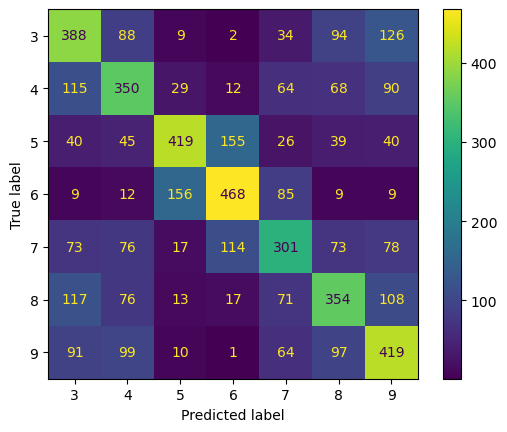

In [22]:
# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
fig = ConfusionMatrixDisplay(cm, display_labels=best_model.classes_)
fig.plot()
plt.show()

In [23]:
# Log Loss
log_loss(y_test, y_pred_proba)

1.4036780364789534

### Interpretabilidade

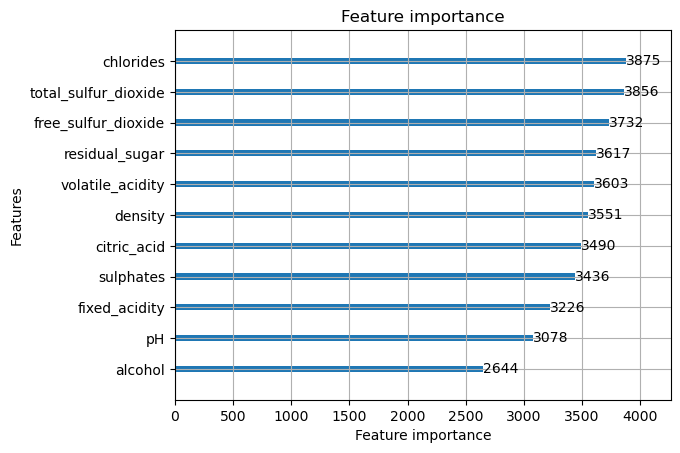

In [24]:
# Importância das variáveis
plot_importance(best_model)
plt.show()

In [ ]:
# Visualizar árvore de decisão
plot_tree(best_model, figsize=(20, 20), show_info=['split_gain', 'internal_value', 'internal_count', 'leaf_count'])
plt.show()